Plot AWS versus WRF(ERA-Interim).  All plots focus on "best" AWS sites. Use first 20 years of the AWS record (1996-2015), ignore most recent.
======

Import custom modules for working with model and AWS data
----

In [3]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.text import Text
from datetime import datetime

%load_ext autoreload
%autoreload 2
from model import Model
from GCNet import GCNet
from plotUtils import PlotUtils

pd.options.mode.chained_assignment = None

Function: subset a variable by years, months, QC
---

In [4]:
def subsetData( X, yrRange = None, monRange = None, qcFunc = None, qcLevel = None, qcIX = None):
    """
        yrRange = (year1, year2), i.e., a range of years
        monRange = (m1, m2, m3...), i.e., a list of explicit month numbers
        qcFunc = function handle for qcStats
        qcLevel = x, i.e., a percent cutoff
        qcIX = existing index for QC slicing
    """

    # first, subset by year range
    if yrRange is not None:
        yrStart = yrRange[0]
        yrEnd = yrRange[1]
        yearSub = range( yrStart, yrEnd+1 )
        Xnew = X.loc[ X['year'].isin(yearSub) ]
        X = Xnew

    # second, subset by month range
    if monRange is not None:
        Xnew = X.loc[ X['month'].isin(monRange) ]
        X = Xnew

    # third, subset by data quality
    if qcLevel is not None:
        if qcIX is None:  # create a new QC index
            qcPct = qcFunc( X.iloc[:,:-2] )
            qcIX = qcPct > qcLevel

        Xtemp = X.iloc[:,:-2]  # temporarily drop time, year and month columns
        Xbest = Xtemp.iloc[:,qcIX]
        Xbest['month'] = X['month']  # restore month column
        X = Xbest

    # drop sites with no valid data
    Xvalid = X.dropna(axis='columns',how='all')
    
    if 'year' in Xvalid.columns:
        Xvalid.drop('year', axis=1, inplace=True)
    
    # return data subset and the QC index used
    return ( Xvalid, qcIX )

Function: create a title string
---

In [5]:
def makeTitle( modelName, varName, srcFile, yrRange, monStr = None, qcFlag = False ):
    # build up a title string from variable components
    
    titleStr = modelName
    titleStr = titleStr+' Daily '+varName
    titleStr = titleStr+' '+str(yrRange[0])+'-'+str(yrRange[1])
    if monStr is not None:
        titleStr = titleStr+', '+monStr
    if srcFile is not None:
        titleStr = titleStr+', '+srcFile+' vs Best AWS'
    else:
        titleStr = titleStr+', Closest vs Interpolated'
    if srcFile is not None:
        if qcFlag:
            titleStr = titleStr+' ('+qcCutoffStr+')'
    return titleStr

Global settings
---

In [6]:
modelName = "WRF ERAI"
qcCutoff = 50
qcCutoffStr = "> "+str(qcCutoff)+"%"

Syr = 1996 # beginning of AWS record (ignoring partial 1995 data)
Eyr = 2015 # end of WRF(ERAI) runs

allStr = "All Year"

Setup plotting
----

In [7]:
plotOptions = { "saveFigure": False }
# plotOptions = { "saveFigure": True }
P = PlotUtils( plotOptions )

Load AWS metadata
----

In [8]:
home = os.path.expanduser("~")
metaFN = "site_info.nc"
gcnetDir = home+"/Documents/GCNet/current"
dataFN = gcnetDir+"/gcnet.allStationData_d_365.nc"
A = GCNet( metaFN, dataFN )
A.loadMeta()

Read AWS time and data, add columns for "year" and "month"
-----

In [9]:
time = A.loadData( "time", True )
Taws = A.loadData( "AirT1", True )
awsCols = Taws.columns.values
# print awsCols

# add column with just the year (for subsetting later)
Taws['year'] = Taws["Time"].apply( lambda Taws : 
                                    datetime(year=Taws.year, month=Taws.month, day=Taws.day).year)
# add column with just the month (for subsetting later)
Taws['month'] = Taws["Time"].apply( lambda Taws : 
                                    datetime(year=Taws.year, month=Taws.month, day=Taws.day).month)

# drop column 1 (Time)
Taws = Taws.iloc[:,1:]

hours since 1900-01-01 00:00:00
noleap
RHS: Resetting value 18.121666
LHS: Resetting value 14.764

/Users/dbr/python_modules/GCNet.py:149: RuntimeWarning: invalid value encountered in greater
  Y = np.array( X )
/Users/dbr/python_modules/GCNet.py:97: RuntimeWarning: invalid value encountered in greater
  Xqc = np.where( X > 20., np.nan, X )
/Users/dbr/python_modules/GCNet.py:151: RuntimeWarning: invalid value encountered in greater
  Yqc = np.where( Yqc > 1.e36, np.nan, Yqc )


Read/create ERA Interim metadata
----

In [10]:
suff = "1986-2015"
# #  interpolated data
# modelFN = "erai_tas_interp_"+suff+".nc"
# Mint = Model("wrf_geog.nc", modelFN)
# Mint.loadMeta()

# closest point data
modelFN = "wrf_erai_tas_closest_"+suff+".nc"
Mcl = Model("wrf_geog.nc", modelFN)
Mcl.loadMeta()

# geography
minLon = -70 + 360
maxLon = -15 + 360
minLat = 58
maxLat = 86.5
Mcl.setDomain( (minLat, maxLat, minLon, maxLon) )

# variable
varName = "tas"

2d dataset


Load closest-point WRF(ERAI) data
------

In [11]:
srcFile = "Closest"
timeModel = Mcl.loadData( "time", True )
Tmodel1 = Mcl.loadData( varName, True )
Tmodel1.columns = awsCols

# add column with just the year (for subsetting later)
Tmodel1['year'] = Tmodel1["Time"].apply( lambda Tmodel1 : 
                                    datetime(year=Tmodel1.year, month=Tmodel1.month, day=Tmodel1.day).year)
# add column with just the month (for subsetting later)
Tmodel1['month'] = Tmodel1["Time"].apply( lambda Tmodel1 : 
                                    datetime(year=Tmodel1.year, month=Tmodel1.month, day=Tmodel1.day).month)

# drop column 1 (Time)
Tmodel1 = Tmodel1.iloc[:,1:]

Closest, WRF(ERAI) period, subset to JJA
---

y-axis limits: -35, 15


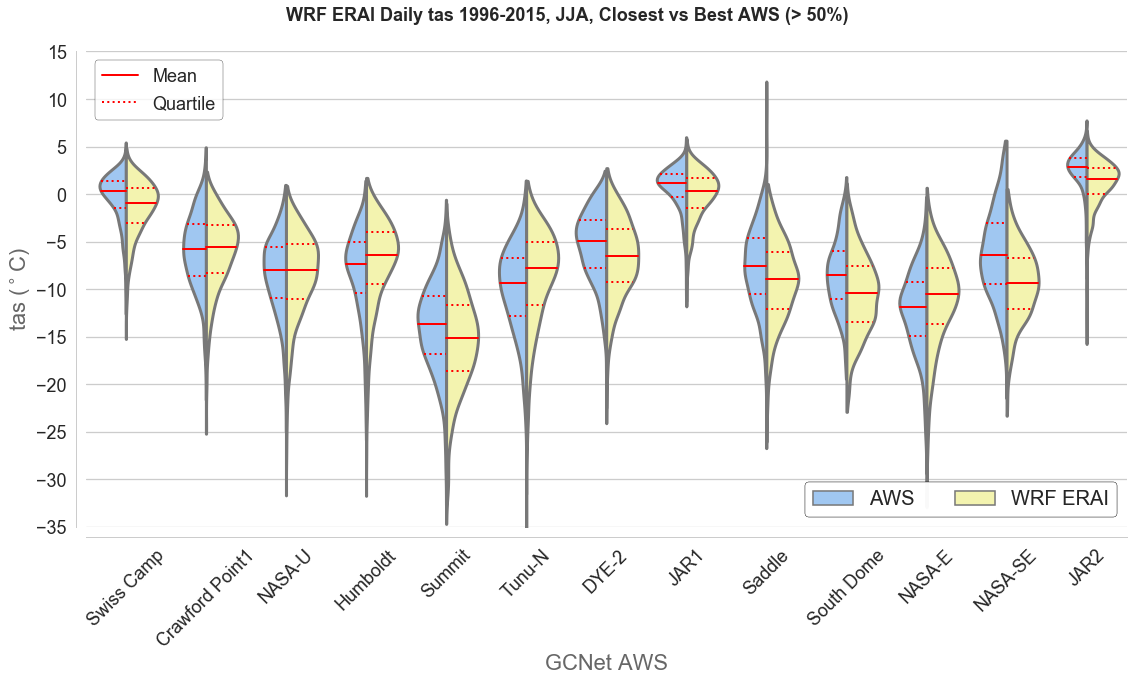

In [12]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
subStr = "JJA"
monSub = [6,7,8]
P.setOption( {"bandWidth": 0.25, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, None, subStr, "eps" )

Closest, WRF(ERAI) period, subset to Jun
---

Plot type Jun not in yAxisValues table
Skipping setting of y axis limits


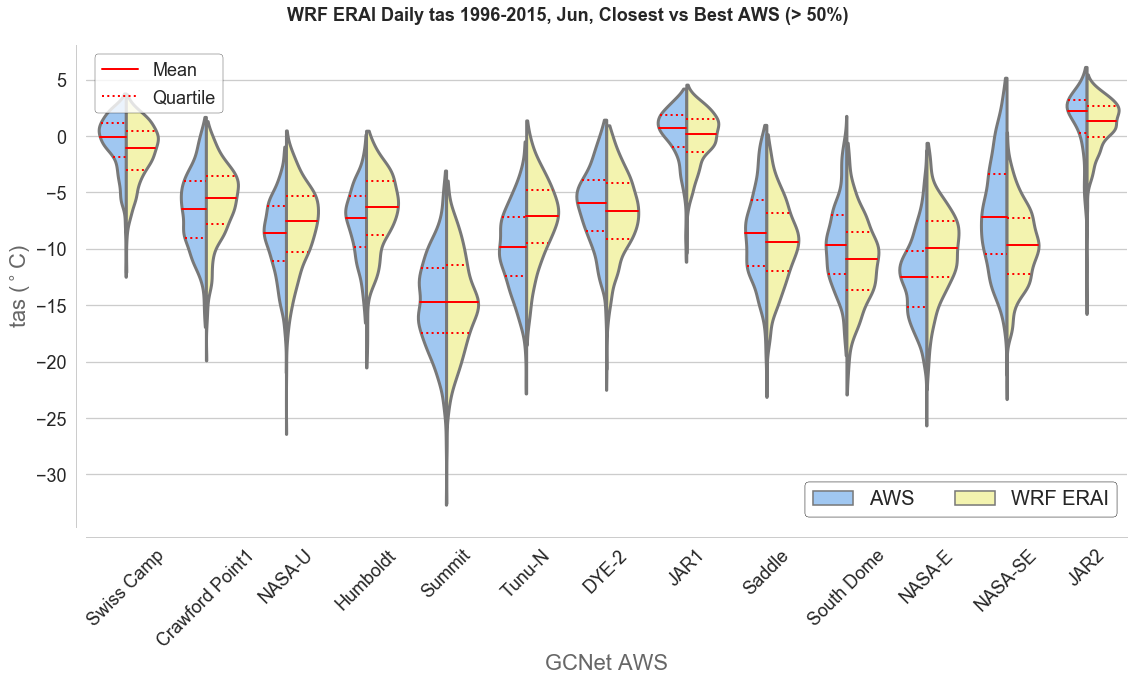

In [13]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
subStr = "Jun"
monSub = [6]
P.setOption( {"bandWidth": 0.25, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, None, subStr, "eps" )

Closest, WRF(ERAI) period, subset to Jul
---

y-axis limits: -27, 20


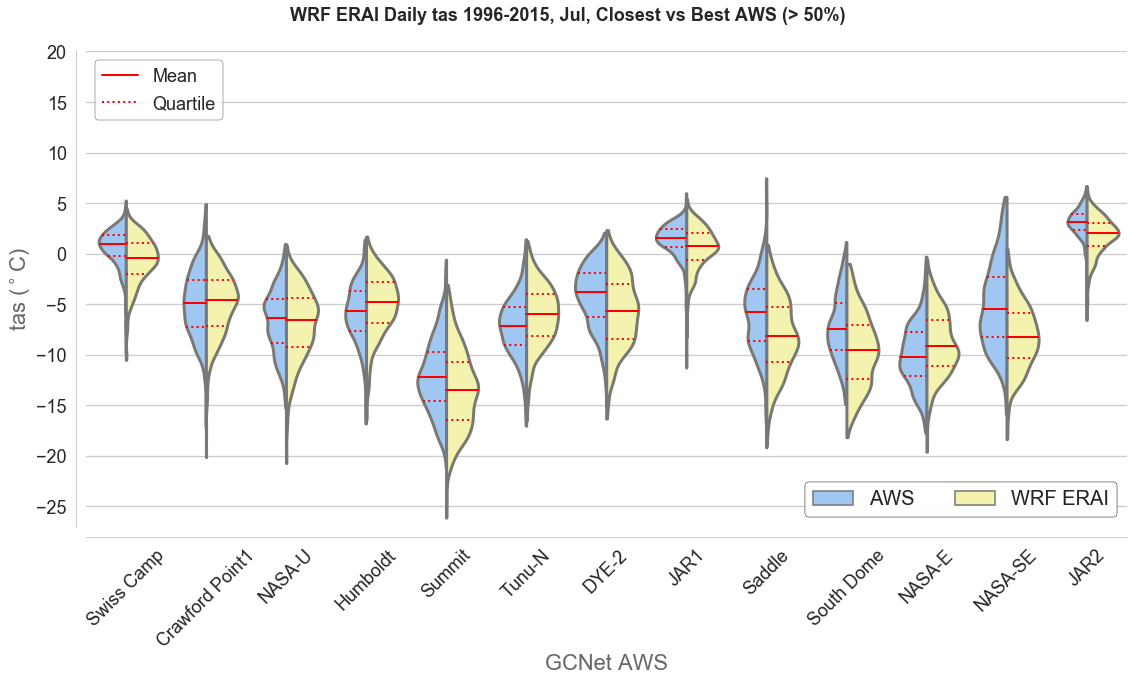

In [14]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
subStr = "Jul"
monSub = [7]
P.setOption( {"bandWidth": 0.25, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, None, subStr, "eps" )

Closest, WRF(ERAI) period, subset to Aug
---

Plot type Aug not in yAxisValues table
Skipping setting of y axis limits


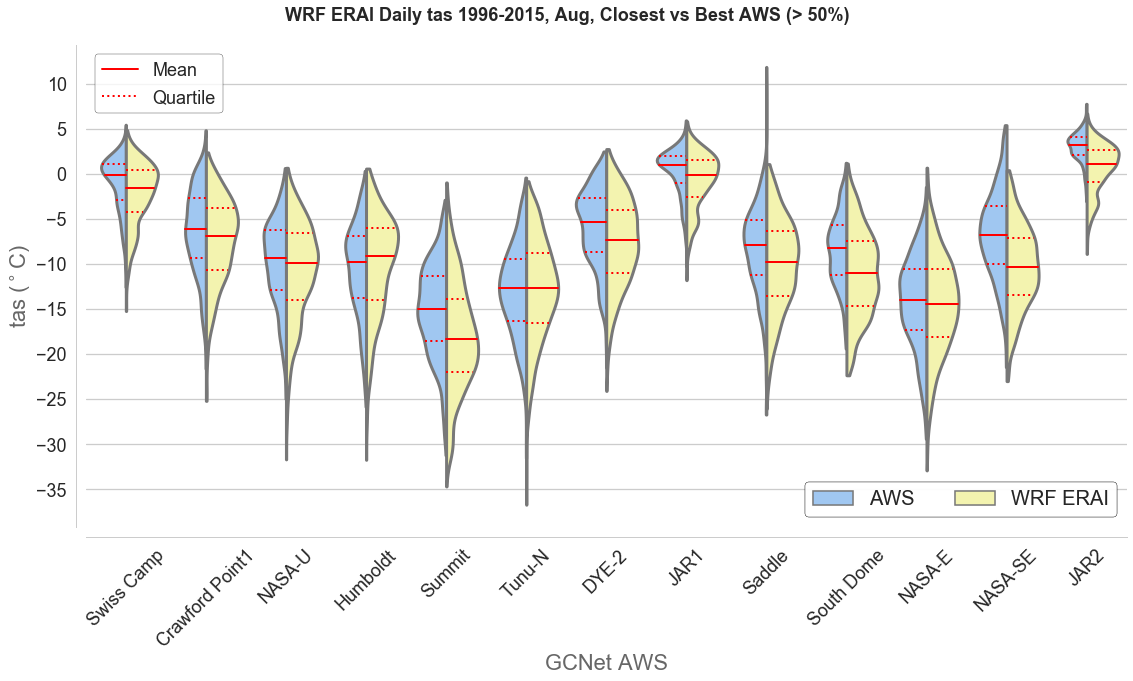

In [15]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
subStr = "Aug"
monSub = [8]
P.setOption( {"bandWidth": 0.25, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, None, subStr, "eps" )

Load interpolated WRF(ERAI) data
------
NOTE: have not done interpolated data for wrf(erai) yet and may NOT do it...

In [27]:
# srcFile = "Interpolated"
# timeModel = Mint.loadData( "time", True )
# Tmodel2 = Mint.loadData( varName, True )
# Tmodel2.columns = awsCols

# # add column with just the year (for subsetting later)
# Tmodel2['year'] = Tmodel2["Time"].apply( lambda Tmodel2 : 
#                                     datetime(year=Tmodel2.year, month=Tmodel2.month, day=Tmodel2.day).year)
# Tmodel2['month'] = Tmodel2["Time"].apply( lambda Tmodel2 : 
#                                     datetime(year=Tmodel2.year, month=Tmodel2.month, day=Tmodel2.day).month)

# # drop column 1 (Time)
# Tmodel2 = Tmodel2.iloc[:,1:]

Interpolated, WRF(ERAI) period, subset to JJA
-----------

In [28]:
# bandWidth=0.2
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# subStr = "JJA"
# monSub = [6, 7, 8]

# TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
# TmodelValid, _ = subsetData( Tmodel2, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
# makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

# saveFigure( modelName, varName, srcFile, yrRange, subStr, "eps" )

Interpolated, WRF(ERAI) period, subset to Jun
-----------

In [28]:
# bandWidth=0.2
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# subStr = "Jun"
# monSub = [6]

# TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
# TmodelValid, _ = subsetData( Tmodel2, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
# makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

# saveFigure( modelName, varName, srcFile, yrRange, subStr, "eps" )

Interpolated, WRF(ERAI) period, subset to Jul
-----------

In [28]:
# bandWidth=0.2
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# subStr = "Jul"
# monSub = [7]

# TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
# TmodelValid, _ = subsetData( Tmodel2, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
# makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

# saveFigure( modelName, varName, srcFile, yrRange, subStr, "eps" )

Interpolated, WRF(ERAI) period, subset to Aug
-----------

In [1]:
# bandWidth=0.2
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# subStr = "Aug"
# monSub = [8]

# TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
# TmodelValid, _ = subsetData( Tmodel2, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, srcFile, yrRange, subStr, True )
# makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

# saveFigure( modelName, varName, srcFile, yrRange, subStr, "eps" )

Closest vs Interpolated, WRF(ERAI) period, JJA
-----------

In [ ]:
# bandWidth=0.2
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# qcCutoff = 50
# subStr = "JJA"
# monSub = [6,7,8]

# TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
# Tmodel1Valid, _ = subsetData( Tmodel1,  yrRange, monSub, A.qcStats, qcCutoff, qcIX )
# Tmodel2Valid, _ = subsetData( Tmodel2, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, None, yrRange, subStr, True )
# makePlots( Tmodel1Valid, Tmodel2Valid, titleStr, "Closest", "Interpolated" )

# saveFigure( modelName, varName, None, yrRange, subStr, "eps" )